# California vehicle fuel type count by zip code

### Load Python tools

In [2]:
import pandas as pd
import geopandas as gpd
import pyarrow
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import weightedcalcs as wc
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

In [191]:
src = pd.read_csv('https://data.ca.gov/dataset/15179472-adeb-4df6-920a-20640d02b08c/\
resource/d304108a-06c1-462f-a144-981dd0109900/\
download/vehicle-fuel-type-count-by-zip-code.csv', low_memory=False)

In [192]:
src.columns = src.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [193]:
src.rename(columns={"zip_code": "zip"}, inplace=True)

In [194]:
src.vehicles.sum()

31137994

In [195]:
src = src[(src['model_year'] != '2019') & (src['model_year'] != '<2006') & (src['zip'] != 'OOS')]

In [226]:
src.vehicles.sum()

19485599

In [223]:
nongas = src[(src['fuel'] != 'Gasoline')]

In [225]:
nongas.vehicles.sum()

3213912

In [197]:
make = src.groupby(['make']).agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [220]:
model_year = src.groupby(['model_year']).agg('sum').reset_index()

In [262]:
model_year.sort_values(by='model_year', ascending=False)

,model_year,vehicles
12,2018,1572034
11,2017,2141868
10,2016,2072606
9,2015,2002628
8,2014,1677875
7,2013,1644620
6,2012,1354947
5,2011,1101920
4,2010,996703
3,2009,834319


In [227]:
fuel = nongas.groupby(['fuel']).agg('sum').reset_index()

In [228]:
fuel.sort_values(by='vehicles', ascending=False)

,fuel,vehicles
2,Flex-Fuel,1018550
3,Hybrid Gasoline,994696
1,Diesel and Diesel Hybrid,753609
0,Battery Electric,214671
7,Plug-in Hybrid,201969
5,Natural Gas,22968
4,Hydrogen Fuel Cell,5092
6,Other,2357


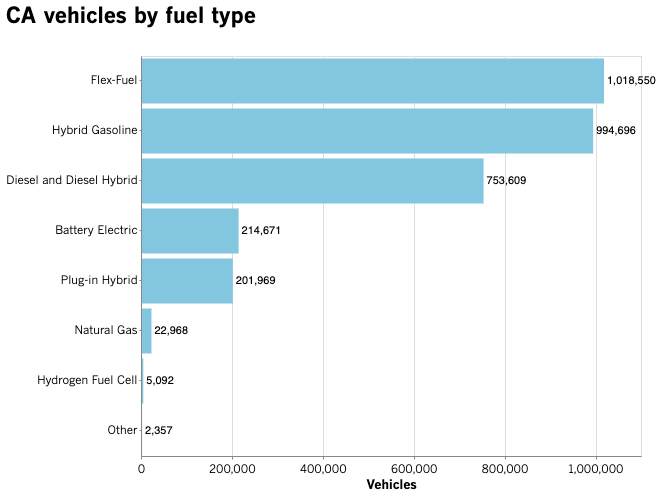

In [252]:
chart_fuels = alt.Chart(fuel).mark_bar().encode(
    y=alt.Y('fuel:N', title=' ',
        sort=alt.EncodingSortField(
            field="vehicles",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(vehicles):Q", title="Vehicles", axis=alt.Axis(format='', tickCount=5))
)

chart_fuels_text = chart_fuels.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(text=alt.Text('sum(vehicles)', format=',')
)


(chart_fuels + chart_fuels_text)\
.properties(height=400, width=500, title='CA vehicles by fuel type')

In [229]:
duty = src.groupby(['duty']).agg('size').reset_index(name='total')

In [230]:
zip_code = src.groupby(['zip']).agg('sum').reset_index()

In [256]:
zip_code_nongas = nongas.groupby(['zip']).agg('sum').reset_index()

In [260]:
zip_code_nongas.sort_values(by='vehicles',\
    ascending=False).head(10)

,zip,vehicles
44,90045,18010
1476,94080,10747
904,92626,10514
1017,92868,9989
11,90012,9493
1170,93308,9377
756,92335,8906
1438,94010,8822
417,91710,8724
592,92101,8457


In [231]:
sum_by_zip = pd.pivot_table(src, values='vehicles', \
                            index=['zip'], columns=['fuel'], aggfunc=np.sum, fill_value=0).reset_index()

sum_by_zip.columns = sum_by_zip.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

sum_by_zip["total"] = sum_by_zip.sum(axis=1)

In [232]:
sum_by_zip.sort_values(by='total', ascending=False).head(5)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,hydrogen_fuel_cell,natural_gas,other,plug_in_hybrid,total
45,90045,420,605,11978,109120,4466,19,138,0,384,127130
1520,94080,307,1519,3761,92399,4872,9,38,2,239,103146
782,92336,180,1706,2664,46467,1736,7,31,0,443,53234
660,92154,115,4196,2154,42291,1256,0,4,0,140,50156
426,91709,533,1139,1847,41681,2389,36,30,1,717,48373


In [233]:
sum_by_zip['other'] = sum_by_zip.apply\
    (lambda x: x['hydrogen_fuel_cell'] + x['natural_gas'] + x['other'], axis=1)
sum_by_zip.drop(['hydrogen_fuel_cell', 'natural_gas'], axis=1, inplace=True)
sum_by_zip.drop([0], inplace=True)

In [253]:
sum_by_zip.sort_values(by='total', ascending=False).head(20)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner
45,90045,420,605,11978,109120,4466,157,384,127130,Flex fuel
1520,94080,307,1519,3761,92399,4872,49,239,103146,Hybrid gasoline
782,92336,180,1706,2664,46467,1736,38,443,53234,Flex fuel
660,92154,115,4196,2154,42291,1256,4,140,50156,Diesel and diesel hybrid
426,91709,533,1139,1847,41681,2389,67,717,48373,Hybrid gasoline
191,90650,129,1170,2122,42241,1446,56,251,47415,Flex fuel
427,91710,284,2519,2866,38056,1494,1097,464,46780,Flex fuel
979,92683,331,780,1355,41233,2175,46,411,46331,Hybrid gasoline
908,92592,254,1662,2464,38763,2188,18,479,45828,Flex fuel
341,91342,160,1754,2325,39299,1858,12,310,45718,Flex fuel


In [235]:
#which non-gas vehicle is most popular in each zip?
sum_by_zip['winner'] = \
sum_by_zip[['hybrid_gasoline','battery_electric','diesel_and_diesel_hybrid',\
                   'flex_fuel','plug_in_hybrid', 'other']].idxmax(axis=1)

In [236]:
sum_by_zip.sort_values(by='total', ascending=False).head(5)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner
45,90045,420,605,11978,109120,4466,157,384,127130,flex_fuel
1520,94080,307,1519,3761,92399,4872,49,239,103146,hybrid_gasoline
782,92336,180,1706,2664,46467,1736,38,443,53234,flex_fuel
660,92154,115,4196,2154,42291,1256,4,140,50156,diesel_and_diesel_hybrid
426,91709,533,1139,1847,41681,2389,67,717,48373,hybrid_gasoline


In [237]:
sum_by_zip['winner'] = sum_by_zip['winner'].str.replace('_', ' ', regex=False).str.capitalize()

In [238]:
sum_by_zip.head()

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner
1,90001,10,508,820,15406,413,4,44,17205,Flex fuel
2,90002,22,300,753,14110,386,2,27,15600,Flex fuel
3,90003,16,366,885,18507,522,10,39,20345,Flex fuel
4,90004,248,265,443,19940,1878,16,251,23041,Hybrid gasoline
5,90005,71,126,217,11052,857,8,105,12436,Hybrid gasoline


### Clean "jenks" breaks for TOTAL field

In [239]:
breaks \
= jenkspy.jenks_breaks(sum_by_zip.total, nb_class=7)

In [240]:
breaks

[1.0, 3499.0, 9905.0, 16350.0, 23391.0, 32528.0, 53234.0, 127130.0]

---

# Geography

### ZIP code points

In [27]:
zips_point = gpd.read_file('/Users/mhustiles/data/data/GIS/zipcodes.geojson')

In [87]:
zips_point['zip'] = zips_point['zip'].astype(str)

In [89]:
ca_zips_point = zips_point[zips_point['state'] == 'CA']

### ZIP code boundaries

In [133]:
zips_poly = gpd.read_file('/Users/mhustiles/data/data/GIS/california/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp')

In [134]:
zips_poly.head()

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry
0,36083,8600000US36083,36083,659750662,5522919,"(POLYGON ((-85.63224699999999 32.280982, -85.6..."
1,35441,8600000US35441,35441,172850429,8749105,"(POLYGON ((-87.83287399999999 32.844372, -87.8..."
2,35051,8600000US35051,35051,280236456,5427285,"POLYGON ((-86.743844 33.250019, -86.7380189999..."
3,35121,8600000US35121,35121,372736030,5349303,"POLYGON ((-86.58526599999999 33.94743, -86.580..."
4,35058,8600000US35058,35058,178039922,3109259,"(POLYGON ((-86.87884199999999 34.211959, -86.8..."


In [135]:
zips_poly.rename(columns={"ZCTA5CE10": "zip"}, inplace=True)

In [136]:
ca_zips_poly_merged =  zips_poly.merge(sum_by_zip, on='zip')

In [140]:
ca_zips_poly_merged.head(1)

,zip,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner
0,93308,8600000US93308,93308,818436705,1790905,"(POLYGON ((-118.963713 35.595182, -118.960574 ...",63,4781,3927,19295,535,3,68,28672,Diesel and diesel hybrid


In [138]:
ca_zips_poly_merged.to_file('/Users/mhustiles/data/github/notebooks/\
california-fuel-vehicles/output/ca_zips_poly_merged.geojson', driver='GeoJSON')

### Merge ZIP points & polygons with vehicle totals

In [90]:
ca_zips_point_merged = ca_zips_point.merge(sum_by_zip, on='zip')

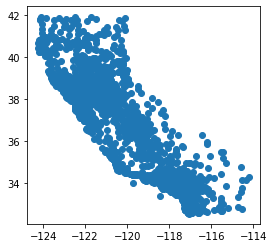

In [91]:
ca_zips_point_merged.plot()

In [108]:
ca_zips_point_merged.to_file('/Users/mhustiles/data/github/notebooks\
/california-fuel-vehicles/output/ca_zips_point_merged.geojson', driver='GeoJSON')

In [139]:
!tippecanoe --force -r1 -pk -pf -Z5 -z13 -o \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_poly_merged.mbtiles \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_poly_merged.geojson

For layer 0, using name "ca_zips_poly_merged"
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_poly_merged.geojson: Warning: GeoJSON specified projection "urn:ogc:def:crs:EPSG::4269", not the expected "urn:ogc:def:crs:OGC:1.3:CRS84".
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_poly_merged.geojson: If "urn:ogc:def:crs:OGC:1.3:CRS84" is not the expected projection, use -s to specify the right one.
2104 features, 1719464 bytes of geometry, 82231 bytes of separate metadata, 107246 bytes of string pool
  99.9%  13/1403/3274  


In [130]:
!tippecanoe --force -r1 -pk -pf -Z5 -z13 -o \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_point_merged.mbtiles \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_point_merged.geojson

For layer 0, using name "ca_zips_point_merged"
2421 features, 146776 bytes of geometry, 16 bytes of separate metadata, 54710 bytes of string pool
  99.9%  13/1432/3310  
